# Проект по анализу данных с сайтов новостей. Часть2. Классификация.

In [367]:
from navec import Navec
import pandas as pd
import numpy as np
import pymorphy3
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from navec import Navec
import pandas as pd
import numpy as np
import pymorphy3
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
nltk.download('punkt')
nltk.download('stopwords')

from tqdm import tqdm
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kukof\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kukof\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [368]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kukof\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kukof\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [369]:
navec = Navec.load('navec_news_v1_1B_250K_300d_100q.tar')

In [370]:
def preprocess(text, stop_words, punctuation_marks, morph):
    tokens = word_tokenize(text.lower())
    preprocessed_text = []
    for token in tokens:
        if token not in punctuation_marks:
            lemma = morph.parse(token)[0].normal_form
            if lemma not in stop_words:
                preprocessed_text.append(lemma)
    return preprocessed_text

In [371]:
punctuation_marks = ['!', ',', '(', ')', ':', '-', '?', '.', '..', '...']
stop_words = stopwords.words("russian")
morph = pymorphy3.MorphAnalyzer()

In [372]:
df = pd.read_pickle('df.p', compression='gzip')
df.head()

,url,source,title,content,datetime,topic,year,month,weekday,len_title,len_content,lifetime
0,https://lenta.ru//news/2023/10/22/v-velikobrit...,lenta,В Великобритании слили в сеть личный номер тел...,Личный номер телефона премьер-министра Великоб...,2023-10-22,crime,2023,October,Sunday,68,674,27250.0
1,https://lenta.ru//news/2023/10/22/kitay-vyyavi...,lenta,Китай выявил шпионившего в пользу США на оборо...,Спецслужбы Китая выявили случай шпионажа в пол...,2023-10-22,crime,2023,October,Sunday,62,1063,27250.0
2,https://lenta.ru//news/2023/10/17/v-belgii-lik...,lenta,В Бельгии ликвидировали подозреваемого в напад...,"Полиция в Бельгии нейтрализовала человека, кот...",2023-10-17,crime,2023,October,Tuesday,61,842,34450.0
3,https://lenta.ru//news/2023/10/16/missiyu-oon-...,lenta,Миссию ООН обокрали в секторе Газа,Ближневосточное агентство ООН для помощи палес...,2023-10-16,crime,2023,October,Monday,34,1136,35890.0
4,https://lenta.ru//news/2023/10/13/vo-frantsii-...,lenta,Во Франции задержали еще одного человека с нож...,Французская полиция задержала еще одного воору...,2023-10-13,crime,2023,October,Friday,64,852,40210.0


In [373]:
df['text'] = df.title +' ' + df.content

In [374]:
stop_words.extend(['что', 'это', 'так', 'вот', 'быть', 'как', 'в', '—', 'к', 'за', 'из',
                   'из-за','на', 'ок', 'кстати', 'который', 'мочь', 'весь', 'еще', 'также', 'свой',
                   'ещё', 'самый', 'ул', 'комментарий', "известно", "оценил", "назвал", "нашли", "обнаружили", "оценили",
                   'рассказал', "рассказали",  "новости", "рассказала","названы", "назвали", "назвала", "заявил", "почему"])

In [375]:
%%time
df['clean_text'] =df.text.apply(lambda x: preprocess(x, stop_words, punctuation_marks, morph))

CPU times: total: 1h 4min 33s
Wall time: 1h 27min 1s


In [376]:
def natasha_embeddings(text, embedding_size = 300):

    text_embeddings = np.zeros(embedding_size)
    cnt = 0
    for tocken in text:
        embedding = navec.get(tocken, navec['<unk>'])
        text_embeddings += np.array(embedding)
        cnt += 1
    if cnt:
        text_embeddings = text_embeddings / cnt

    return text_embeddings

In [377]:
df['embeddings_text'] =df.clean_text.apply(lambda x: natasha_embeddings(x))

In [378]:
print(df['embeddings_text'])

0        [0.11605068692006171, 0.0012662092404853967, 0...
1        [-0.020258064346962444, -0.13146968401759584, ...
2        [0.005342952075968438, 0.009192577009148236, 0...
3        [0.012677966732450802, -0.1386169811953669, 0....
4        [0.1741687209578231, -0.07105986633211035, -0....
                               ...                        
43090    [0.037810056507326315, -0.08784186361992959, -...
43091    [-0.11235952071588615, 0.0034194521605968474, ...
43092    [-0.241828714878383, 0.03770019325681708, -0.1...
43093    [-0.052933771756464895, -0.1145081561033244, -...
43094    [-0.0712757224853461, -0.01649792624016603, -0...
Name: embeddings_text, Length: 38992, dtype: object


In [379]:
X_ne = list(df.embeddings_text.values)
y_ne = df.topic.values

In [380]:
X_train, X_test, y_train, y_test = train_test_split(df.embeddings_text.values, df.topic, random_state=42, stratify=df.topic)

In [271]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

In [272]:
from sklearn.utils.class_weight import compute_class_weight
class_weight = compute_class_weight('balanced', classes = np.unique(y_train), y=y_train)
classes = np.unique(y_train)
class_weights = {k: v for k, v in zip(classes, class_weight)}
class_weights

{0: 1.791033806957374,
 1: 3.3326495726495726,
 2: 0.48512798394187223,
 3: 0.6906780661769916,
 4: 2.80841256122155,
 5: 1.306352184400965,
 6: 0.8206999130019925,
 7: 0.4834598026087388,
 8: 2.760169891458235,
 9: 0.7920910075839653,
 10: 0.910375743236933,
 11: 0.7157297045938471,
 12: 9.654671508748763}

In [348]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler

In [352]:
X_ne = list(df.embeddings_text.values)
y_ne = df.topic.values

In [325]:
rus = RandomOverSampler(random_state=0)
X_oes, y_oes  = rus.fit_resample(X_ne, y_ne)
X_train_oes, X_test_oes, y_train_oes, y_test_oes = train_test_split(X_oes, y_oes, random_state=42, stratify=y_oes)
encoder = LabelEncoder()
encoder.fit(y_train_oes)
y_train_oes = encoder.transform(y_train_oes)
y_test_oes = encoder.transform(y_test_oes)

In [321]:
rus = RandomUnderSampler(random_state=0)
X_res, y_res  = rus.fit_resample(X_ne, y_ne)
X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(X_res, y_res, random_state=42, stratify=y_res)
encoder = LabelEncoder()
encoder.fit(y_train_res)
y_train_res = encoder.transform(y_train_res)
y_test_res = encoder.transform(y_test_res)

In [354]:
smote = SMOTE()
X_smote, y_smote  = smote.fit_resample(X_ne, y_ne)
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_smote, y_smote, random_state=42, stratify=y_smote)
encoder = LabelEncoder()
encoder.fit(y_train_smote)
y_train_smote = encoder.transform(y_train_smote)
y_test_smote = encoder.transform(y_test_smote)
y_smote = encoder.fit_transform(y_smote)

In [366]:
adasyn = ADASYN(sampling_strategy = 'minority', random_state=42, n_neighbors=10)
#X_ada, y_ada  = adasyn.fit_resample(X_ne, y_ne,ratio='auto')
new_data = data
new_classes = classes
for i in range(LEN(CLASSES)-1):
    NEW_DATA, NEW_CLASSES =

In [ ]:

X_train_ada, X_test_ada, y_train_ada, y_test_ada = train_test_split(X_ada, y_ada, random_state=42, stratify=y_smote)
encoder = LabelEncoder()
encoder.fit(y_train_ada)
y_train_ada = encoder.transform(y_train_ada)
y_test_ada = encoder.transform(y_test_ada)
y_ada= encoder.fit_transform(y_ada)
y_ne = encoder.fit_transform(y_ne)

In [ ]:
#with SMOTE
pipe = Pipeline([('clf', LogisticRegression(random_state=42, max_iter=1000))])

pipe.fit(X_train_smote, y_train_smote)

print(classification_report(y_test_smote, pipe.predict(X_test_smote)))

In [334]:
#with SMOTE
pipe = Pipeline([('clf', LogisticRegression(random_state=42, max_iter=1000))])

pipe.fit(X_train_smote, y_train_smote)

print(classification_report(y_test_smote, pipe.predict(X_test_smote)))

              precision    recall  f1-score   support

           0       0.56      0.58      0.57      1551
           1       0.74      0.87      0.80      1551
           2       0.62      0.60      0.61      1551
           3       0.48      0.43      0.46      1551
           4       0.66      0.75      0.70      1551
           5       0.39      0.32      0.35      1551
           6       0.58      0.59      0.58      1551
           7       0.60      0.58      0.59      1551
           8       0.66      0.69      0.68      1551
           9       0.49      0.47      0.48      1551
          10       0.60      0.54      0.57      1551
          11       0.44      0.37      0.40      1551
          12       0.71      0.92      0.80      1551

    accuracy                           0.59     20163
   macro avg       0.58      0.59      0.58     20163
weighted avg       0.58      0.59      0.58     20163



In [326]:
#with RandomOverSampler
pipe = Pipeline([('clf', LogisticRegression(random_state=42, max_iter=1000))])

pipe.fit(X_train_oes, y_train_oes)

print(classification_report(y_test_oes, pipe.predict(X_test_oes)))

              precision    recall  f1-score   support

           0       0.52      0.52      0.52      1551
           1       0.70      0.83      0.76      1551
           2       0.63      0.60      0.62      1551
           3       0.47      0.41      0.44      1551
           4       0.62      0.72      0.67      1551
           5       0.37      0.29      0.33      1551
           6       0.55      0.57      0.56      1551
           7       0.58      0.57      0.57      1551
           8       0.63      0.63      0.63      1551
           9       0.47      0.46      0.47      1551
          10       0.55      0.51      0.53      1551
          11       0.45      0.36      0.40      1551
          12       0.66      0.86      0.74      1551

    accuracy                           0.56     20163
   macro avg       0.55      0.56      0.56     20163
weighted avg       0.55      0.56      0.56     20163



In [322]:
#with RandomUnderSampler
pipe = Pipeline([('clf', LogisticRegression(random_state=42, max_iter=1000))])

pipe.fit(X_train_res, y_train_res)

print(classification_report(y_test_res, pipe.predict(X_test_res)))

              precision    recall  f1-score   support

           0       0.36      0.42      0.39        77
           1       0.62      0.74      0.67        78
           2       0.46      0.50      0.48        78
           3       0.37      0.33      0.35        78
           4       0.55      0.67      0.60        78
           5       0.31      0.29      0.30        78
           6       0.51      0.51      0.51        78
           7       0.50      0.55      0.52        78
           8       0.56      0.47      0.51        78
           9       0.47      0.45      0.46        77
          10       0.44      0.32      0.37        78
          11       0.35      0.21      0.26        77
          12       0.66      0.83      0.74        78

    accuracy                           0.49      1011
   macro avg       0.47      0.49      0.48      1011
weighted avg       0.47      0.49      0.48      1011



In [274]:
#with class_weights
pipe = Pipeline([('clf', LogisticRegression(random_state=42, max_iter=1000, class_weight = class_weights))])

pipe.fit(list(X_train), y_train)

print(classification_report(y_test, pipe.predict(list(X_test))))

              precision    recall  f1-score   support

           0       0.34      0.48      0.40       418
           1       0.30      0.79      0.44       225
           2       0.74      0.58      0.65      1546
           3       0.53      0.43      0.48      1086
           4       0.31      0.70      0.43       267
           5       0.23      0.28      0.26       574
           6       0.55      0.56      0.56       914
           7       0.74      0.55      0.63      1551
           8       0.32      0.56      0.41       272
           9       0.51      0.46      0.48       947
          10       0.52      0.45      0.48       823
          11       0.58      0.35      0.43      1047
          12       0.13      0.74      0.22        78

    accuracy                           0.50      9748
   macro avg       0.45      0.53      0.45      9748
weighted avg       0.56      0.50      0.51      9748



In [273]:
#as with class_weight
pipe = Pipeline([('clf', LogisticRegression(random_state=42, max_iter=1000))])

pipe.fit(list(X_train), y_train)
pipe.fit(list(X_train), y_train)

print(classification_report(y_test, pipe.predict(list(X_test))))

              precision    recall  f1-score   support

           0       0.47      0.34      0.39       418
           1       0.53      0.26      0.35       225
           2       0.65      0.73      0.69      1546
           3       0.49      0.61      0.54      1086
           4       0.51      0.28      0.36       267
           5       0.31      0.16      0.21       574
           6       0.53      0.57      0.55       914
           7       0.62      0.75      0.68      1551
           8       0.43      0.27      0.33       272
           9       0.52      0.58      0.55       947
          10       0.55      0.43      0.49       823
          11       0.56      0.55      0.55      1047
          12       0.22      0.03      0.05        78

    accuracy                           0.55      9748
   macro avg       0.49      0.43      0.44      9748
weighted avg       0.54      0.55      0.54      9748



In [15]:
pipe = Pipeline([('clf', LogisticRegression(random_state=42, max_iter=1000))])

pipe.fit(list(X_train), y_train)

print(classification_report(y_test, pipe.predict(list(X_test))))

              precision    recall  f1-score   support

           0       0.44      0.35      0.39       425
           1       0.55      0.25      0.34       237
           2       0.67      0.63      0.65       707
           3       0.51      0.63      0.57      1081
           4       0.48      0.26      0.34       263
           5       0.67      0.73      0.70       889
           6       0.30      0.16      0.21       571
           7       0.49      0.56      0.52       854
           8       0.59      0.76      0.66      1543
           9       0.44      0.25      0.32       286
          10       0.52      0.57      0.54       906
          11       0.00      0.00      0.00        83
          12       0.56      0.48      0.52       744
          13       0.58      0.59      0.59      1080
          14       0.14      0.01      0.02        79

    accuracy                           0.55      9748
   macro avg       0.46      0.42      0.42      9748
weighted avg       0.53   

In [19]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [335]:
#with SMOTE
pipe = Pipeline([('clf', SVC())])

pipe.fit(X_train_smote, y_train_smote)

print(classification_report(y_test_smote, pipe.predict(X_test_smote)))

              precision    recall  f1-score   support

           0       0.70      0.75      0.73      1551
           1       0.87      0.97      0.92      1551
           2       0.75      0.71      0.73      1551
           3       0.57      0.54      0.55      1551
           4       0.71      0.85      0.77      1551
           5       0.56      0.41      0.47      1551
           6       0.69      0.72      0.70      1551
           7       0.72      0.65      0.68      1551
           8       0.77      0.84      0.80      1551
           9       0.59      0.59      0.59      1551
          10       0.78      0.64      0.70      1551
          11       0.57      0.45      0.50      1551
          12       0.74      0.99      0.85      1551

    accuracy                           0.70     20163
   macro avg       0.69      0.70      0.69     20163
weighted avg       0.69      0.70      0.69     20163



In [327]:
#with RandomOverSampler
pipe = Pipeline([('clf', SVC())])

pipe.fit(X_train_oes, y_train_oes)

print(classification_report(y_test_oes, pipe.predict(X_test_oes)))

              precision    recall  f1-score   support

           0       0.68      0.72      0.70      1551
           1       0.82      0.95      0.88      1551
           2       0.75      0.70      0.73      1551
           3       0.55      0.52      0.53      1551
           4       0.68      0.84      0.75      1551
           5       0.53      0.39      0.45      1551
           6       0.66      0.68      0.67      1551
           7       0.71      0.62      0.66      1551
           8       0.75      0.82      0.78      1551
           9       0.59      0.57      0.58      1551
          10       0.74      0.62      0.67      1551
          11       0.55      0.42      0.48      1551
          12       0.73      1.00      0.84      1551

    accuracy                           0.68     20163
   macro avg       0.67      0.68      0.67     20163
weighted avg       0.67      0.68      0.67     20163



In [323]:
#with RandomUnderSampler
pipe = Pipeline([('clf', SVC())])

pipe.fit(X_train_res, y_train_res)

print(classification_report(y_test_res, pipe.predict(X_test_res)))

              precision    recall  f1-score   support

           0       0.37      0.39      0.38        77
           1       0.69      0.86      0.77        78
           2       0.53      0.58      0.55        78
           3       0.40      0.47      0.43        78
           4       0.56      0.79      0.66        78
           5       0.40      0.32      0.36        78
           6       0.55      0.51      0.53        78
           7       0.46      0.56      0.51        78
           8       0.67      0.50      0.57        78
           9       0.49      0.47      0.48        77
          10       0.45      0.32      0.37        78
          11       0.54      0.17      0.26        77
          12       0.66      0.87      0.75        78

    accuracy                           0.53      1011
   macro avg       0.52      0.52      0.51      1011
weighted avg       0.52      0.53      0.51      1011



In [276]:
#class_weight
pipe = Pipeline([('clf', SVC(class_weight = class_weights))])

pipe.fit(list(X_train), y_train)

print(classification_report(y_test, pipe.predict(list(X_test))))

              precision    recall  f1-score   support

           0       0.45      0.59      0.51       418
           1       0.41      0.87      0.56       225
           2       0.78      0.67      0.72      1546
           3       0.58      0.53      0.55      1086
           4       0.28      0.72      0.40       267
           5       0.33      0.33      0.33       574
           6       0.62      0.66      0.64       914
           7       0.77      0.59      0.67      1551
           8       0.37      0.65      0.48       272
           9       0.58      0.53      0.55       947
          10       0.60      0.49      0.54       823
          11       0.64      0.35      0.45      1047
          12       0.13      0.65      0.21        78

    accuracy                           0.56      9748
   macro avg       0.50      0.59      0.51      9748
weighted avg       0.61      0.56      0.57      9748



In [275]:
#as with class_weight
pipe = Pipeline([('clf', SVC())])

pipe.fit(list(X_train), y_train)

print(classification_report(y_test, pipe.predict(list(X_test))))

              precision    recall  f1-score   support

           0       0.50      0.43      0.46       418
           1       0.70      0.48      0.57       225
           2       0.69      0.78      0.73      1546
           3       0.53      0.65      0.58      1086
           4       0.61      0.27      0.37       267
           5       0.39      0.15      0.22       574
           6       0.60      0.66      0.63       914
           7       0.64      0.78      0.70      1551
           8       0.45      0.31      0.37       272
           9       0.58      0.64      0.61       947
          10       0.65      0.48      0.55       823
          11       0.62      0.63      0.62      1047
          12       0.00      0.00      0.00        78

    accuracy                           0.61      9748
   macro avg       0.54      0.48      0.49      9748
weighted avg       0.59      0.61      0.59      9748



C:\Users\kukof\PycharmProjects\pythonProject5\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\kukof\PycharmProjects\pythonProject5\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\kukof\PycharmProjects\pythonProject5\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [22]:
pipe = Pipeline([('clf', SVC())])

pipe.fit(list(X_train), y_train)

print(classification_report(y_test, pipe.predict(list(X_test))))

              precision    recall  f1-score   support

           0       0.47      0.37      0.42       425
           1       0.68      0.48      0.56       237
           2       0.71      0.69      0.70       707
           3       0.55      0.67      0.60      1081
           4       0.55      0.25      0.34       263
           5       0.71      0.75      0.73       889
           6       0.36      0.17      0.23       571
           7       0.55      0.64      0.59       854
           8       0.61      0.78      0.69      1543
           9       0.51      0.36      0.42       286
          10       0.57      0.65      0.61       906
          11       0.50      0.02      0.05        83
          12       0.67      0.50      0.57       744
          13       0.62      0.66      0.64      1080
          14       0.00      0.00      0.00        79

    accuracy                           0.60      9748
   macro avg       0.54      0.47      0.48      9748
weighted avg       0.59   

C:\Users\kukof\PycharmProjects\pythonProject5\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kukof\PycharmProjects\pythonProject5\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kukof\PycharmProjects\pythonProject5\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

In [336]:
#with SMOTE
X_train_smote_full, y_train_smote_full = X_train_smote, y_train_smote
X_train_smote_, X_val_smote, y_train_smote_, y_val_smote = train_test_split(X_train_smote_full, y_train_smote_full, test_size=0.1,  random_state=42)
input_dim = np.stack(X_train_smote_,0).shape[1]
model = Sequential()
model.add(layers.Dense(2056, input_dim=input_dim, activation='selu', kernel_initializer='lecun_normal'))
model.add(layers.Dense(32, input_dim=128, activation='selu', kernel_initializer='lecun_normal'))
model.add(layers.Dense(32, input_dim=128, activation='selu', kernel_initializer='lecun_normal'))
model.add(layers.Dense(15, input_dim=64, activation='softmax'))
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer="sgd",metrics=['accuracy'])
model.fit(np.stack(X_train_smote_,0), y_train_smote_, epochs=30,
                           validation_data=(np.stack(X_val_smote,0), y_val_smote))

Epoch 1/30
1702/1702 [==============================] - 15s 8ms/step - loss: 1.7311 - accuracy: 0.4364 - val_loss: 1.4482 - val_accuracy: 0.5017
Epoch 2/30
1702/1702 [==============================] - 14s 8ms/step - loss: 1.3748 - accuracy: 0.5307 - val_loss: 1.3464 - val_accuracy: 0.5356
Epoch 3/30
1702/1702 [==============================] - 14s 8ms/step - loss: 1.2725 - accuracy: 0.5601 - val_loss: 1.2397 - val_accuracy: 0.5684
Epoch 4/30
1702/1702 [==============================] - 14s 8ms/step - loss: 1.2136 - accuracy: 0.5797 - val_loss: 1.2419 - val_accuracy: 0.5655
Epoch 5/30
1702/1702 [==============================] - 14s 8ms/step - loss: 1.1751 - accuracy: 0.5912 - val_loss: 1.2634 - val_accuracy: 0.5639
Epoch 6/30
1702/1702 [==============================] - 15s 9ms/step - loss: 1.1454 - accuracy: 0.6012 - val_loss: 1.1878 - val_accuracy: 0.5829
Epoch 7/30
1702/1702 [==============================] - 15s 9ms/step - loss: 1.1226 - accuracy: 0.6071 - val_loss: 1.1694 - val_ac

In [ ]:
#smote
def build_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=3, max_value=8, default=2)
    n_neurons = hp.Int("n_neurons", min_value=50, max_value=120)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2,
                             sampling="log")
    optimizer = hp.Choice("optimizer", values=["sgd", "adam"])
    if optimizer == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten())
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation="elu", kernel_initializer="he_normal"))
        model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(15, activation="softmax"))
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model


random_search_tuner = kt.RandomSearch(
    build_model, objective="val_accuracy", max_trials=15, overwrite=True,
    directory="my_fashion_mnist", project_name="my_rnd_search", seed=42)
random_search_tuner.search(np.stack(X_train_smote_, 0), y_train_smote_, epochs=10,
                           validation_data=(np.stack(X_val_smote,0), y_val_smote))
top3_models = random_search_tuner.get_best_models(num_models=3)
best_model = top3_models[0]
top3_params = random_search_tuner.get_best_hyperparameters(num_trials=3)
top3_params[0].value  # best hyperparameter values
best_trial = random_search_tuner.oracle.get_best_trials(num_trials=1)[0]
best_trial.summary()

Trial 1 Complete [00h 01m 36s]
val_accuracy: 0.5281865000724792

Best val_accuracy So Far: 0.5281865000724792
Total elapsed time: 00h 01m 36s

Search: Running Trial #2

Value             |Best Value So Far |Hyperparameter
8                 |6                 |n_hidden
74                |52                |n_neurons
0.0012483         |0.00065625        |learning_rate
sgd               |sgd               |optimizer

Epoch 1/10
1702/1702 [==============================] - 10s 5ms/step - loss: 2.2265 - accuracy: 0.3044 - val_loss: 1.7597 - val_accuracy: 0.4419
Epoch 2/10
1702/1702 [==============================] - 8s 5ms/step - loss: 1.7426 - accuracy: 0.4326 - val_loss: 1.5397 - val_accuracy: 0.4971
Epoch 3/10
 407/1702 [======>.......................] - ETA: 5s - loss: 1.6113 - accuracy: 0.4684

In [399]:
#smote
model = tf.keras.Sequential()
for _ in range(best_hyperparameters['n_hidden']):
    model.add(
        tf.keras.layers.Dense(best_hyperparameters['n_neurons'], activation="relu", kernel_initializer="he_normal"))
    model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(15, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adamax(learning_rate=best_hyperparameters['learning_rate']),
              metrics=["accuracy"])
#model.fit(np.stack(X_train_smote_, 0), y_train_smote_, validation_data=(np.stack(X_val_smote,0), y_val_smote), shuffle=True, epochs=EPOCHS, callbacks=[early_stop],
          #verbose=False)

#score = model.evaluate(np.stack(X_val_smote,0), y_val_smote, verbose=0)
model.fit(np.asarray(X_train_smote_full), y_train_smote_full)

1891/1891 [==============================] - 21s 9ms/step - loss: 1.4065 - accuracy: 0.5384


In [402]:
test_loss, test_accuracy = model.evaluate(np.stack(X_test_smote,0), y_test_smote)
predict = model.predict(np.stack(X_test_smote,0))
classes = np.argmax(predict, axis=1)
print(classification_report(y_test_smote, classes))

631/631 [==============================] - 2s 4ms/step
              precision    recall  f1-score   support

           0       0.62      0.60      0.61      1551
           1       0.78      0.94      0.85      1551
           2       0.67      0.57      0.62      1551
           3       0.49      0.43      0.46      1551
           4       0.64      0.82      0.72      1551
           5       0.41      0.39      0.40      1551
           6       0.61      0.59      0.60      1551
           7       0.61      0.58      0.60      1551
           8       0.67      0.79      0.72      1551
           9       0.54      0.44      0.49      1551
          10       0.63      0.51      0.57      1551
          11       0.47      0.40      0.43      1551
          12       0.72      0.95      0.82      1551
          14       0.00      0.00      0.00         0

    accuracy                           0.62     20163
   macro avg       0.56      0.57      0.56     20163
weighted avg       0.61  

C:\Users\kukof\PycharmProjects\pythonProject5\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

C:\Users\kukof\PycharmProjects\pythonProject5\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

C:\Users\kukof\PycharmProjects\pythonProject5\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



In [24]:
from keras.models import Sequential
from keras import layers

input_dim = np.stack(X_train,0).shape[1]  # Number of features


In [25]:
input_dim = np.stack(X_train,0).shape[1]
model = Sequential()
model.add(layers.Dense(2056, input_dim=input_dim, activation='selu', kernel_initializer='lecun_normal'))
model.add(layers.Dense(32, input_dim=128, activation='selu', kernel_initializer='lecun_normal'))
model.add(layers.Dense(32, input_dim=128, activation='selu', kernel_initializer='lecun_normal'))
model.add(layers.Dense(15, input_dim=64, activation='softmax'))

In [26]:
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer="sgd",metrics=['accuracy'])

In [27]:
model.fit(np.stack(X_train,0), y_train, epochs=30,
                           validation_data=(np.stack(X_val,0), y_val))

Epoch 1/30
823/823 [==============================] - 17s 18ms/step - loss: 1.8692 - accuracy: 0.4277 - val_loss: 1.6338 - val_accuracy: 0.4807
Epoch 2/30
823/823 [==============================] - 15s 18ms/step - loss: 1.5599 - accuracy: 0.4992 - val_loss: 1.4921 - val_accuracy: 0.5156
Epoch 3/30
823/823 [==============================] - 14s 17ms/step - loss: 1.4620 - accuracy: 0.5215 - val_loss: 1.4313 - val_accuracy: 0.5197
Epoch 4/30
823/823 [==============================] - 15s 18ms/step - loss: 1.4074 - accuracy: 0.5346 - val_loss: 1.3788 - val_accuracy: 0.5306
Epoch 5/30
823/823 [==============================] - 14s 17ms/step - loss: 1.3696 - accuracy: 0.5436 - val_loss: 1.3541 - val_accuracy: 0.5313
Epoch 6/30
823/823 [==============================] - 14s 17ms/step - loss: 1.3409 - accuracy: 0.5487 - val_loss: 1.3365 - val_accuracy: 0.5361
Epoch 7/30
823/823 [==============================] - 14s 17ms/step - loss: 1.3189 - accuracy: 0.5550 - val_loss: 1.3325 - val_accuracy:

In [28]:
model.fit(np.stack(X_train,0), y_train, epochs=10,
                           validation_data=(np.stack(X_val,0), y_val))

Epoch 1/10
823/823 [==============================] - 15s 18ms/step - loss: 1.1182 - accuracy: 0.6088 - val_loss: 1.2354 - val_accuracy: 0.5696
Epoch 2/10
823/823 [==============================] - 14s 17ms/step - loss: 1.1119 - accuracy: 0.6102 - val_loss: 1.2453 - val_accuracy: 0.5600
Epoch 3/10
823/823 [==============================] - 14s 17ms/step - loss: 1.1085 - accuracy: 0.6104 - val_loss: 1.2414 - val_accuracy: 0.5597
Epoch 4/10
823/823 [==============================] - 14s 17ms/step - loss: 1.1016 - accuracy: 0.6168 - val_loss: 1.2787 - val_accuracy: 0.5532
Epoch 5/10
823/823 [==============================] - 14s 17ms/step - loss: 1.0993 - accuracy: 0.6150 - val_loss: 1.2079 - val_accuracy: 0.5788
Epoch 6/10
823/823 [==============================] - 14s 17ms/step - loss: 1.0935 - accuracy: 0.6186 - val_loss: 1.2137 - val_accuracy: 0.5740
Epoch 7/10
823/823 [==============================] - 12s 15ms/step - loss: 1.0907 - accuracy: 0.6179 - val_loss: 1.2374 - val_accuracy:

In [29]:
import keras_tuner as kt
import tensorflow as tf

def build_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=4, max_value=8, default=2)
    n_neurons = hp.Int("n_neurons", min_value=50, max_value=100)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2,
                             sampling="log")
    optimizer = hp.Choice("optimizer", values=["sgd", "adam"])
    if optimizer == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten())
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation="relu"))
    model.add(tf.keras.layers.Dense(15, activation="softmax"))
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model

In [30]:
random_search_tuner = kt.RandomSearch(
    build_model, objective="val_accuracy", max_trials=15, overwrite=True,
    directory="my_fashion_mnist", project_name="my_rnd_search", seed=42)
random_search_tuner.search(np.stack(X_train,0), y_train, epochs=10,
                           validation_data=(np.stack(X_val,0), y_val))

Trial 15 Complete [00h 00m 34s]
val_accuracy: 0.5699145197868347

Best val_accuracy So Far: 0.6061538457870483
Total elapsed time: 00h 12m 24s


In [31]:
top3_models = random_search_tuner.get_best_models(num_models=3)
best_model = top3_models[0]

In [32]:
top3_params = random_search_tuner.get_best_hyperparameters(num_trials=3)
top3_params[0].values  # best hyperparameter values

{'n_hidden': 8,
 'n_neurons': 72,
 'learning_rate': 0.0005509513888645584,
 'optimizer': 'adam'}

In [33]:
best_trial = random_search_tuner.oracle.get_best_trials(num_trials=1)[0]
best_trial.summary()

Trial 08 summary
Hyperparameters:
n_hidden: 8
n_neurons: 72
learning_rate: 0.0005509513888645584
optimizer: adam
Score: 0.6061538457870483


In [34]:
best_trial.metrics.get_last_value("val_accuracy")

0.6061538457870483

In [35]:
best_model.fit(np.stack(X_train_full,0), y_train_full, epochs=10)
test_loss, test_accuracy = best_model.evaluate(np.stack(X_test,0), y_test)

Epoch 1/10
914/914 [==============================] - 4s 3ms/step - loss: 1.0379 - accuracy: 0.6335
Epoch 2/10
914/914 [==============================] - 3s 3ms/step - loss: 1.0093 - accuracy: 0.6412
Epoch 3/10
914/914 [==============================] - 3s 3ms/step - loss: 0.9851 - accuracy: 0.6488
Epoch 4/10
914/914 [==============================] - 3s 3ms/step - loss: 0.9608 - accuracy: 0.6555
Epoch 5/10
914/914 [==============================] - 3s 3ms/step - loss: 0.9406 - accuracy: 0.6621
Epoch 6/10
914/914 [==============================] - 3s 3ms/step - loss: 0.9215 - accuracy: 0.6667
Epoch 7/10
914/914 [==============================] - 3s 3ms/step - loss: 0.9107 - accuracy: 0.6695
Epoch 8/10
914/914 [==============================] - 3s 3ms/step - loss: 0.8912 - accuracy: 0.6745
Epoch 9/10
914/914 [==============================] - 3s 3ms/step - loss: 0.8832 - accuracy: 0.6755
Epoch 10/10
305/305 [==============================] - 1s 2ms/step - loss: 1.2313 - accuracy: 0.5888

In [213]:
def build_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=5, max_value=8, default=2)
    n_neurons = hp.Int("n_neurons", min_value=50, max_value=100)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2,
                             sampling="log")
    optimizer = hp.Choice("optimizer", values=["sgd", "adam"])
    if optimizer == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten())
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation="elu", kernel_initializer = "he_normal"))
        model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(15, activation="softmax"))
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model

In [214]:
random_search_tuner = kt.RandomSearch(
    build_model, objective="val_accuracy", max_trials=15, overwrite=True,
    directory="my_fashion_mnist", project_name="my_rnd_search", seed=42)
random_search_tuner.search(np.stack(X_train,0), y_train, epochs=10,
                           validation_data=(np.stack(X_val,0), y_val))

Trial 15 Complete [00h 01m 24s]
val_accuracy: 0.5808547139167786

Best val_accuracy So Far: 0.6037606596946716
Total elapsed time: 00h 19m 40s


In [215]:
top3_models = random_search_tuner.get_best_models(num_models=3)
best_model = top3_models[0]

In [216]:
top3_params = random_search_tuner.get_best_hyperparameters(num_trials=3)
top3_params[0].values  # best hyperparameter values

{'n_hidden': 6,
 'n_neurons': 62,
 'learning_rate': 0.00905127409782462,
 'optimizer': 'adam'}

In [217]:
best_trial = random_search_tuner.oracle.get_best_trials(num_trials=1)[0]
best_trial.summary()

Trial 02 summary
Hyperparameters:
n_hidden: 6
n_neurons: 62
learning_rate: 0.00905127409782462
optimizer: adam
Score: 0.6037606596946716


In [41]:
def build_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=1, max_value=8, default=2)
    n_neurons = hp.Int("n_neurons", min_value=50, max_value=100)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2,
                             sampling="log")
    optimizer = hp.Choice("optimizer", values=["sgd", "adam", 'nadam', 'adamax'])
    if optimizer == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    if optimizer == "adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    if optimizer == "nadam":
        optimizer = tf.keras.optimizers.Nadam(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Adamax(learning_rate=learning_rate)


    model = tf.keras.Sequential()
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation="relu", kernel_initializer = "he_normal"))
        model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(15, activation="softmax"))
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model

In [42]:
random_search_tuner = kt.RandomSearch(
    build_model, objective="val_accuracy", max_trials=15, overwrite=True,
    directory="my_fashion_mnist", project_name="my_rnd_search", seed=42)
random_search_tuner.search(np.stack(X_train,0), y_train, epochs=10,
                           validation_data=(np.stack(X_val,0), y_val))

Trial 15 Complete [00h 00m 38s]
val_accuracy: 0.5764102339744568

Best val_accuracy So Far: 0.5924786329269409
Total elapsed time: 00h 21m 10s


In [43]:
top3_models = random_search_tuner.get_best_models(num_models=3)
best_model = top3_models[0]

In [44]:
top3_params = random_search_tuner.get_best_hyperparameters(num_trials=3)
top3_params[0].values  # best hyperparameter values

{'n_hidden': 4,
 'n_neurons': 62,
 'learning_rate': 0.00905127409782462,
 'optimizer': 'nadam'}

In [45]:
best_trial = random_search_tuner.oracle.get_best_trials(num_trials=1)[0]
best_trial.summary()

Trial 02 summary
Hyperparameters:
n_hidden: 4
n_neurons: 62
learning_rate: 0.00905127409782462
optimizer: nadam
Score: 0.5924786329269409


In [47]:
def build_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=1, max_value=8, default=2)
    n_neurons = hp.Int("n_neurons", min_value=50, max_value=100)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2,
                             sampling="log")
    optimizer = hp.Choice("optimizer", values=["sgd", "adam", 'nadam', 'adamax'])
    if optimizer == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    if optimizer == "adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    if optimizer == "nadam":
        optimizer = tf.keras.optimizers.Nadam(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Adamax(learning_rate=learning_rate)


    model = tf.keras.Sequential()
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation="relu", kernel_initializer = "he_normal"))
    model.add(tf.keras.layers.Dense(15, activation="softmax"))
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model

In [48]:
random_search_tuner = kt.RandomSearch(
    build_model, objective="val_accuracy", max_trials=15, overwrite=True,
    directory="my_fashion_mnist", project_name="my_rnd_search", seed=42)
random_search_tuner.search(np.stack(X_train,0), y_train, epochs=10,
                           validation_data=(np.stack(X_val,0), y_val))

Trial 15 Complete [00h 00m 31s]
val_accuracy: 0.5675213932991028

Best val_accuracy So Far: 0.594529926776886
Total elapsed time: 00h 07m 38s


In [49]:
top3_models = random_search_tuner.get_best_models(num_models=3)
best_model = top3_models[0]

In [50]:
best_trial = random_search_tuner.oracle.get_best_trials(num_trials=1)[0]
best_trial.summary()

Trial 09 summary
Hyperparameters:
n_hidden: 7
n_neurons: 57
learning_rate: 0.0003491260272208854
optimizer: nadam
Score: 0.594529926776886


In [51]:
best_trial = random_search_tuner.oracle.get_best_trials(num_trials=1)[0]
best_trial.summary()

Trial 09 summary
Hyperparameters:
n_hidden: 7
n_neurons: 57
learning_rate: 0.0003491260272208854
optimizer: nadam
Score: 0.594529926776886


In [52]:
top3_params = random_search_tuner.get_best_hyperparameters(num_trials=3)
top3_params[0].values

{'n_hidden': 7,
 'n_neurons': 57,
 'learning_rate': 0.0003491260272208854,
 'optimizer': 'nadam'}

In [53]:
def build_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=1, max_value=4, default=2)
    n_neurons = hp.Int("n_neurons", min_value=24, max_value=150)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2,
                             sampling="log")
    optimizer = hp.Choice("optimizer", values=["sgd", "adam", 'nadam', 'adamax'])
    if optimizer == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    if optimizer == "adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    if optimizer == "nadam":
        optimizer = tf.keras.optimizers.Nadam(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Adamax(learning_rate=learning_rate)

    model = tf.keras.Sequential()
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation="relu", kernel_initializer="he_normal"))
        model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(15, activation="softmax"))
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model


random_search_tuner = kt.RandomSearch(
    build_model, objective="val_accuracy", max_trials=15, overwrite=True,
    directory="my_fashion_mnist", project_name="my_rnd_search", seed=42)
random_search_tuner.search(np.stack(X_train, 0), y_train, epochs=10,
                           validation_data=(np.stack(X_val, 0), y_val))

Trial 15 Complete [00h 01m 34s]
val_accuracy: 0.5760684013366699

Best val_accuracy So Far: 0.5907692313194275
Total elapsed time: 00h 18m 36s


In [54]:
top3_models = random_search_tuner.get_best_models(num_models=3)
best_model = top3_models[0]
best_trial = random_search_tuner.oracle.get_best_trials(num_trials=1)[0]
best_trial.summary()

Trial 13 summary
Hyperparameters:
n_hidden: 3
n_neurons: 120
learning_rate: 0.0005510469719519641
optimizer: sgd
Score: 0.5907692313194275


In [55]:
top3_params = random_search_tuner.get_best_hyperparameters(num_trials=3)
top3_params[0].values

{'n_hidden': 3,
 'n_neurons': 120,
 'learning_rate': 0.0005510469719519641,
 'optimizer': 'sgd'}

In [57]:
def build_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=1, max_value=6, default=2)
    n_neurons = hp.Int("n_neurons", min_value=24, max_value=1000)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2,
                             sampling="log")
    optimizer = hp.Choice("optimizer", values=["sgd", "adam", 'nadam', 'adamax'])
    if optimizer == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    #if optimizer == "adam":
        #optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    #if optimizer == "nadam":
        #optimizer = tf.keras.optimizers.Nadam(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Adamax(learning_rate=learning_rate)

    model = tf.keras.Sequential()
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation="relu", kernel_initializer="he_normal"))
        model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(15, activation="softmax"))
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model


random_search_tuner = kt.RandomSearch(
    build_model, objective="val_accuracy", max_trials=30, overwrite=True,
    directory="my_fashion_mnist", project_name="my_rnd_search", seed=42)
random_search_tuner.search(np.stack(X_train, 0), y_train, epochs=10,
                           validation_data=(np.stack(X_val, 0), y_val))

Trial 30 Complete [00h 01m 46s]
val_accuracy: 0.575042724609375

Best val_accuracy So Far: 0.630427360534668
Total elapsed time: 01h 16m 16s


In [58]:
top3_models = random_search_tuner.get_best_models(num_models=3)
best_model = top3_models[0]
best_trial = random_search_tuner.oracle.get_best_trials(num_trials=1)[0]
best_trial.summary()

Trial 27 summary
Hyperparameters:
n_hidden: 5
n_neurons: 714
learning_rate: 0.009022079415210089
optimizer: adamax
Score: 0.630427360534668


In [59]:
top3_params = random_search_tuner.get_best_hyperparameters(num_trials=3)
top3_params[0].values

{'n_hidden': 5,
 'n_neurons': 714,
 'learning_rate': 0.009022079415210089,
 'optimizer': 'adamax'}

# Столбцы title и content

In [60]:
%%time
df['title'] = df.title
df['content'] = df.content
df['clean_title'] = df.title.apply(lambda x: preprocess(x, stop_words, punctuation_marks, morph))
df['clean_content'] = df.content.apply(lambda x: preprocess(x, stop_words, punctuation_marks, morph))

CPU times: total: 31min 27s
Wall time: 49min 17s


In [61]:
df['embeddings_title'] =df.clean_title.apply(lambda x: natasha_embeddings(x))
df['embeddings_content'] =df.clean_content.apply(lambda x: natasha_embeddings(x))

In [62]:
encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

In [63]:
from catboost import CatBoostClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import decomposition
from sklearn import preprocessing
import numpy as np

In [219]:
X = np.hstack((np.array(list(df['embeddings_title'].values)), np.array(list(df['embeddings_content'].values))))
X_train, X_test, y_train, y_test = train_test_split(X, df.topic.values, random_state=42)
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

In [220]:
from keras.models import Sequential
from keras import layers

input_dim = np.stack(X_train,0).shape[1]

In [221]:
X_train_full, y_train_full = X_train, y_train
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.1, random_state=42)

In [222]:
def build_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=1, max_value=6, default=2)
    n_neurons = hp.Int("n_neurons", min_value=24, max_value=1000)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2,
                             sampling="log")
    optimizer = hp.Choice("optimizer", values=["sgd", "adam", 'nadam', 'adamax'])
    if optimizer == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    #if optimizer == "adam":
        #optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    #if optimizer == "nadam":
        #optimizer = tf.keras.optimizers.Nadam(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Adamax(learning_rate=learning_rate)

    model = tf.keras.Sequential()
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation="relu", kernel_initializer="he_normal"))
        model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(15, activation="softmax"))
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model


random_search_tuner = kt.RandomSearch(
    build_model, objective="val_accuracy", max_trials=30, overwrite=True,
    directory="my_fashion_mnist", project_name="my_rnd_search", seed=42)
random_search_tuner.search(np.stack(X_train, 0), y_train, epochs=10,
                           validation_data=(np.stack(X_val, 0), y_val))

Trial 30 Complete [00h 05m 44s]
val_accuracy: 0.5135042667388916

Best val_accuracy So Far: 0.622905969619751
Total elapsed time: 01h 47m 20s


In [223]:
top3_models = random_search_tuner.get_best_models(num_models=3)
best_model = top3_models[0]
best_trial = random_search_tuner.oracle.get_best_trials(num_trials=1)[0]
best_trial.summary()

Trial 27 summary
Hyperparameters:
n_hidden: 5
n_neurons: 714
learning_rate: 0.009022079415210089
optimizer: adamax
Score: 0.622905969619751


In [224]:
top3_params = random_search_tuner.get_best_hyperparameters(num_trials=3)
top3_params[0].values

{'n_hidden': 5,
 'n_neurons': 714,
 'learning_rate': 0.009022079415210089,
 'optimizer': 'adamax'}

In [225]:
best_trial = random_search_tuner.oracle.get_best_trials(num_trials=1)[0]
best_trial.summary()

Trial 27 summary
Hyperparameters:
n_hidden: 5
n_neurons: 714
learning_rate: 0.009022079415210089
optimizer: adamax
Score: 0.622905969619751


In [226]:
best_model.fit(X_train_full, y_train_full, epochs=10)
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)

Epoch 1/10
914/914 [==============================] - 63s 65ms/step - loss: 0.8621 - accuracy: 0.6838
Epoch 2/10
914/914 [==============================] - 59s 65ms/step - loss: 0.8093 - accuracy: 0.7020
Epoch 3/10
914/914 [==============================] - 59s 65ms/step - loss: 0.7583 - accuracy: 0.7154
Epoch 4/10
914/914 [==============================] - 59s 65ms/step - loss: 0.7120 - accuracy: 0.7315
Epoch 5/10
914/914 [==============================] - 59s 65ms/step - loss: 0.6769 - accuracy: 0.7431
Epoch 6/10
914/914 [==============================] - 59s 65ms/step - loss: 0.6533 - accuracy: 0.7490
Epoch 7/10
914/914 [==============================] - 59s 65ms/step - loss: 0.6303 - accuracy: 0.7574
Epoch 8/10
914/914 [==============================] - 60s 65ms/step - loss: 0.6025 - accuracy: 0.7694
Epoch 9/10
914/914 [==============================] - 60s 65ms/step - loss: 0.5868 - accuracy: 0.7719
Epoch 10/10
305/305 [==============================] - 6s 18ms/step - loss: 1.3679

In [249]:
from sklearn.utils.class_weight import compute_class_weight
class_weight = compute_class_weight('balanced', classes = np.unique(y_train), y=y_train)
classes = np.unique(y_train)
class_weights = {k: v for k, v in zip(classes, class_weight)}
class_weights

In [253]:
classes = np.unique(y_train)
class_weights = {k: v for k, v in zip(classes, class_weight)}
class_weights

{0: 1.7995897435897437,
 1: 3.437246963562753,
 2: 0.48925530728334016,
 3: 0.6945243435809474,
 4: 2.758226786837141,
 5: 1.298613509646223,
 6: 0.8085217498156795,
 7: 0.47974845060153115,
 8: 2.807959031260002,
 9: 0.7816750816750817,
 10: 0.9058337635518844,
 11: 0.7279893784748154,
 12: 9.73335798816568}

In [256]:
def build_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=4, max_value=8, default=2)
    n_neurons = hp.Int("n_neurons", min_value=50, max_value=100)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2,
                             sampling="log")
    optimizer = hp.Choice("optimizer", values=["sgd", "adam"])
    if optimizer == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten())
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation="relu"))
    model.add(tf.keras.layers.Dense(15, activation="softmax"))
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model

In [257]:
random_search_tuner = kt.RandomSearch(
    build_model, objective="val_accuracy", max_trials=15, overwrite=True,
    directory="my_fashion_mnist", project_name="my_rnd_search", seed=42)
random_search_tuner.search(np.stack(X_train, 0), y_train, epochs=10,
                           validation_data=(np.stack(X_val, 0), y_val), class_weight = class_weights)

Trial 15 Complete [00h 00m 56s]
val_accuracy: 0.51316237449646

Best val_accuracy So Far: 0.5429059863090515
Total elapsed time: 00h 13m 31s


In [258]:
top3_models = random_search_tuner.get_best_models(num_models=3)
best_model = top3_models[0]

In [259]:
top3_params = random_search_tuner.get_best_hyperparameters(num_trials=3)
top3_params[0].values  # best hyperparameter values

{'n_hidden': 4,
 'n_neurons': 53,
 'learning_rate': 0.00304325168554751,
 'optimizer': 'adam'}

In [260]:
best_trial = random_search_tuner.oracle.get_best_trials(num_trials=1)[0]
print(best_trial.summary())
print(best_trial.metrics.get_last_value("val_accuracy"))

Trial 06 summary
Hyperparameters:
n_hidden: 4
n_neurons: 53
learning_rate: 0.00304325168554751
optimizer: adam
Score: 0.5429059863090515
None
0.5429059863090515


In [227]:
history = best_model.fit(X_train, y_train, epochs=3, validation_data=(X_val, y_val))

Epoch 1/3
823/823 [==============================] - 56s 68ms/step - loss: 0.5464 - accuracy: 0.7838 - val_loss: 0.5543 - val_accuracy: 0.7805
Epoch 2/3
823/823 [==============================] - 55s 67ms/step - loss: 0.5293 - accuracy: 0.7883 - val_loss: 0.6050 - val_accuracy: 0.7638
Epoch 3/3
823/823 [==============================] - 55s 67ms/step - loss: 0.5125 - accuracy: 0.7941 - val_loss: 0.6385 - val_accuracy: 0.7515


In [228]:
max_val_accuracy = max(history.history['val_accuracy'])
model_stats = (history.history['val_accuracy'].index(max_val_accuracy), max_val_accuracy)
print(f"Max validation accuracy : {max_val_accuracy}")
print(f"Epoch                   : {history.history['val_accuracy'].index(max_val_accuracy)}")

Max validation accuracy : 0.780512809753418
Epoch                   : 0


In [229]:
import matplotlib.pyplot as plt

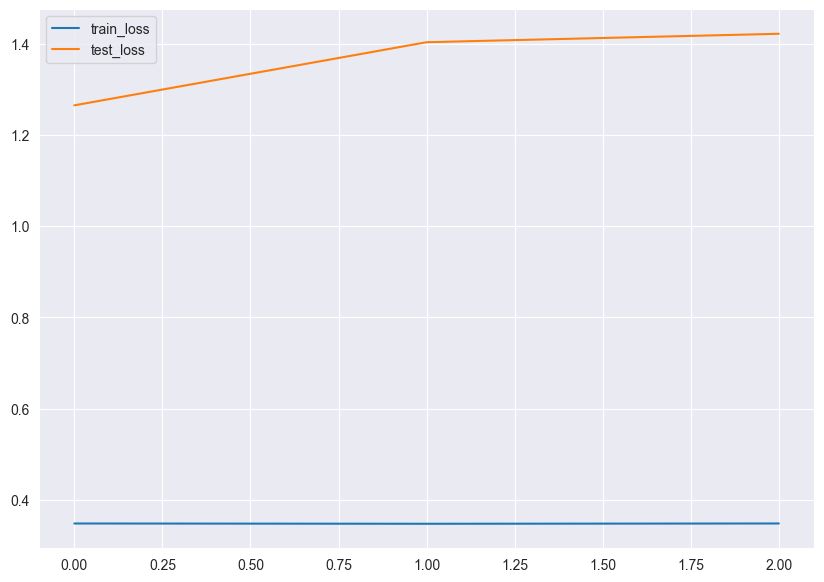

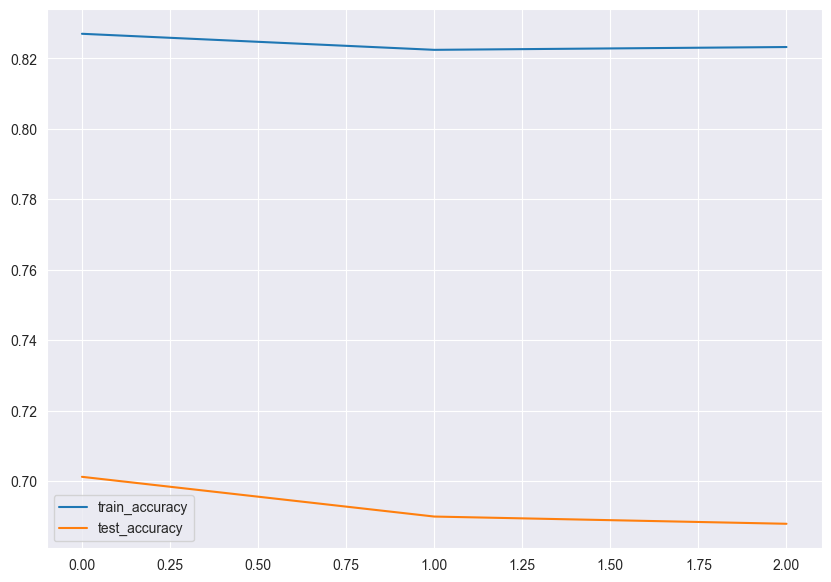

In [119]:
plt.figure(figsize=(10,7))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='test_loss')
plt.legend()
plt.show()

plt.figure(figsize=(10,7))
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='test_accuracy')
plt.legend()
plt.show()

In [ ]:
eval_result = best_model.evaluate(X_test, y_test)
print("[test loss, test accuracy]:", eval_result)

In [122]:
predict=best_model.predict(X_test)
classes=np.argmax(predict,axis=1)
print(classification_report(y_test, classes))

305/305 [==============================] - 2s 5ms/step


In [123]:
print(classification_report(y_test, classes))

              precision    recall  f1-score   support

           0       0.45      0.42      0.43       425
           1       0.63      0.57      0.60       237
           2       0.65      0.72      0.68       707
           3       0.57      0.56      0.56      1081
           4       0.23      0.37      0.28       263
           5       0.74      0.74      0.74       889
           6       0.24      0.18      0.21       571
           7       0.50      0.63      0.56       854
           8       0.69      0.70      0.70      1543
           9       0.41      0.47      0.44       286
          10       0.55      0.65      0.59       906
          11       0.24      0.22      0.23        83
          12       0.66      0.67      0.67       744
          13       0.53      0.32      0.40      1080
          14       0.00      0.00      0.00        79

    accuracy                           0.56      9748
   macro avg       0.47      0.48      0.47      9748
weighted avg       0.56   

In [130]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)

def build_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=1, max_value=6, default=2)
    n_neurons = hp.Int("n_neurons", min_value=24, max_value=1000)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2,
                             sampling="log")
    optimizer = hp.Choice("optimizer", values=["sgd", "adam", 'nadam', 'adamax'])
    if optimizer == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    if optimizer == "adam":
        #optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    if optimizer == "nadam":
        #optimizer = tf.keras.optimizers.Nadam(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Adamax(learning_rate=learning_rate)

    model = tf.keras.Sequential()
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation="relu", kernel_initializer="he_normal"))
        model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(15, activation="softmax"))
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model


random_search_tuner = kt.RandomSearch(build_model, objective="val_accuracy", max_trials=3, overwrite=True, seed=42)

random_search_tuner.search(np.stack(X_train_full, 0), y_train_full, epochs=10,validation_split=0.2, callbacks=[stop_early])

Trial 19 Complete [00h 01m 34s]
val_accuracy: 0.5313729047775269

Best val_accuracy So Far: 0.5927509069442749
Total elapsed time: 00h 26m 13s

Search: Running Trial #20

Value             |Best Value So Far |Hyperparameter
5                 |3                 |n_hidden
929               |261               |n_neurons
0.0010712         |0.0090513         |learning_rate
sgd               |nadam             |optimizer

Epoch 1/10
732/732 [==============================] - 27s 35ms/step - loss: 2.5040 - accuracy: 0.2836 - val_loss: 2.1563 - val_accuracy: 0.3736
Epoch 2/10
732/732 [==============================] - 26s 36ms/step - loss: 1.9218 - accuracy: 0.4222 - val_loss: 1.9872 - val_accuracy: 0.4144
Epoch 3/10
732/732 [==============================] - 26s 35ms/step - loss: 1.6979 - accuracy: 0.4704 - val_loss: 1.9641 - val_accuracy: 0.4187
Epoch 4/10
253/732 [=========>....................] - ETA: 15s - loss: 1.5986 - accuracy: 0.4943

KeyboardInterrupt: 

In [ ]:
top3_models = random_search_tuner.get_best_models(num_models=3)
best_model = top3_models[0]
best_trial = random_search_tuner.oracle.get_best_trials(num_trials=1)[0]
best_trial.summary()

In [ ]:
top3_params = random_search_tuner.get_best_hyperparameters(num_trials=3)
top3_params[0].values

In [ ]:
best_trial = random_search_tuner.oracle.get_best_trials(num_trials=1)[0]
best_trial.summary()

In [ ]:
best_model.fit(X_train_full, y_train_full, epochs=10)
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)

In [ ]:
print("[test loss, test accuracy]:", eval_result)
predict = best_model.predict(X_test)
classes = np.argmax(predict, axis=1)
print(classification_report(y_test, classes))

# Optuna

In [136]:
import optuna




In [186]:
EPOCHS=30
BATCH_SIZE = 32
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)

def objective(trial):

    model = tf.keras.Sequential()
    n_hidden = trial.suggest_int("n_hidden", 1, 6)
    n_neurons = trial.suggest_int("n_neurons", 24, 1000)
    learning_rate = trial.suggest_float("learning_rate", .00001, .001)
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation="relu", kernel_initializer="he_normal"))
        model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Dense(15, activation="softmax"))
    model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adamax(learning_rate=learning_rate),
                  metrics=["accuracy"])

    model.fit(X_train, y_train,
              validation_data = (X_val, y_val),
              shuffle = True,
              epochs = EPOCHS,
              callbacks = [early_stop],
              verbose = False )

    score = model.evaluate(X_val, y_val, verbose=0)

    return score[1]

In [187]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=3)

[I 2023-11-18 08:54:28,569] A new study created in memory with name: no-name-5272330a-414a-4b21-b74a-4191b7566083
[I 2023-11-18 08:59:15,768] Trial 0 finished with value: 0.503247857093811 and parameters: {'n_hidden': 5, 'n_neurons': 699, 'learning_rate': 0.00022847749129048918}. Best is trial 0 with value: 0.503247857093811.
[I 2023-11-18 09:00:31,513] Trial 1 finished with value: 0.5562393069267273 and parameters: {'n_hidden': 2, 'n_neurons': 457, 'learning_rate': 0.00032257422920875745}. Best is trial 1 with value: 0.5562393069267273.
[I 2023-11-18 09:02:55,054] Trial 2 finished with value: 0.5476922988891602 and parameters: {'n_hidden': 2, 'n_neurons': 544, 'learning_rate': 0.00014302340785386124}. Best is trial 1 with value: 0.5562393069267273.


In [188]:
print('Best trial: score {}, params {}'.format(study.best_trial.value, study.best_trial.params))

Best trial: score 0.5562393069267273, params {'n_hidden': 2, 'n_neurons': 457, 'learning_rate': 0.00032257422920875745}


In [189]:
optuna.visualization.plot_optimization_history(study)

In [190]:
print("Training model with best_params {}".format(study.best_params))

Training model with best_params {'n_hidden': 2, 'n_neurons': 457, 'learning_rate': 0.00032257422920875745}


In [191]:
best_trial = study.best_trial

In [192]:
best_hyperparameters = best_trial.params
best_hyperparameters

{'n_hidden': 2, 'n_neurons': 457, 'learning_rate': 0.00032257422920875745}

In [193]:
best_hyperparameters['learning_rate']

0.00032257422920875745

In [194]:
model = tf.keras.Sequential()
for _ in range(best_hyperparameters['n_hidden']):
    model.add(tf.keras.layers.Dense(best_hyperparameters['n_neurons'], activation="relu", kernel_initializer="he_normal"))
    model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(15, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adamax(learning_rate=best_hyperparameters['learning_rate']),
                  metrics=["accuracy"])

In [195]:
model.fit(X_train, y_train, validation_data = (X_val, y_val), shuffle = True, epochs = EPOCHS, callbacks = [early_stop], verbose = False )
score = model.evaluate(X_val, y_val, verbose=0)

In [196]:
model.fit(X_train_full, y_train_full, epochs=EPOCHS)
test_loss, test_accuracy = model.evaluate(X_test, y_test)

Epoch 1/30
914/914 [==============================] - 7s 8ms/step - loss: 0.9337 - accuracy: 0.6768
Epoch 2/30
914/914 [==============================] - 7s 8ms/step - loss: 0.8677 - accuracy: 0.6958
Epoch 3/30
914/914 [==============================] - 7s 8ms/step - loss: 0.8155 - accuracy: 0.7089
Epoch 4/30
914/914 [==============================] - 7s 8ms/step - loss: 0.7752 - accuracy: 0.7224
Epoch 5/30
914/914 [==============================] - 7s 8ms/step - loss: 0.7276 - accuracy: 0.7351
Epoch 6/30
914/914 [==============================] - 7s 8ms/step - loss: 0.6966 - accuracy: 0.7446
Epoch 7/30
914/914 [==============================] - 7s 8ms/step - loss: 0.6600 - accuracy: 0.7591
Epoch 8/30
914/914 [==============================] - 7s 8ms/step - loss: 0.6354 - accuracy: 0.7653
Epoch 9/30
914/914 [==============================] - 7s 8ms/step - loss: 0.6126 - accuracy: 0.7702
Epoch 10/30
914/914 [==============================] - 7s 8ms/step - loss: 0.5888 - accuracy: 0.7767

In [197]:
predict = model.predict(X_test)
classes = np.argmax(predict, axis=1)
print(classification_report(y_test, classes))

305/305 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.40      0.36      0.38       425
           1       0.59      0.57      0.58       237
           2       0.58      0.59      0.58       707
           3       0.47      0.46      0.46      1081
           4       0.30      0.30      0.30       263
           5       0.73      0.74      0.73       889
           6       0.16      0.15      0.15       571
           7       0.43      0.47      0.45       854
           8       0.69      0.69      0.69      1543
           9       0.37      0.34      0.36       286
          10       0.45      0.55      0.50       906
          11       0.33      0.18      0.23        83
          12       0.72      0.56      0.63       744
          13       0.46      0.49      0.47      1080
          14       0.00      0.00      0.00        79

    accuracy                           0.52      9748
   macro avg       0.44  

In [199]:
model = tf.keras.Sequential()
for _ in range(best_hyperparameters['n_hidden']):
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(best_hyperparameters['n_neurons'], activation="relu", kernel_initializer="he_normal"))


model.add(tf.keras.layers.Dense(15, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adamax(learning_rate=best_hyperparameters['learning_rate']),
                  metrics=["accuracy"])

In [200]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), shuffle=True, epochs=EPOCHS, callbacks=[early_stop],
          verbose=False)
score = model.evaluate(X_val, y_val, verbose=0)
model.fit(X_train_full, y_train_full, epochs=EPOCHS)
test_loss, test_accuracy = model.evaluate(X_test, y_test)
predict = model.predict(X_test)
classes = np.argmax(predict, axis=1)
print(classification_report(y_test, classes))

Epoch 1/30
914/914 [==============================] - 10s 11ms/step - loss: 1.0559 - accuracy: 0.6327
Epoch 2/30
914/914 [==============================] - 10s 11ms/step - loss: 0.9698 - accuracy: 0.6599
Epoch 3/30
914/914 [==============================] - 10s 11ms/step - loss: 0.9009 - accuracy: 0.6805
Epoch 4/30
914/914 [==============================] - 10s 11ms/step - loss: 0.8449 - accuracy: 0.6994
Epoch 5/30
914/914 [==============================] - 10s 11ms/step - loss: 0.7962 - accuracy: 0.7144
Epoch 6/30
914/914 [==============================] - 11s 12ms/step - loss: 0.7563 - accuracy: 0.7239
Epoch 7/30
914/914 [==============================] - 11s 12ms/step - loss: 0.7141 - accuracy: 0.7397
Epoch 8/30
914/914 [==============================] - 11s 12ms/step - loss: 0.6788 - accuracy: 0.7497
Epoch 9/30
914/914 [==============================] - 11s 12ms/step - loss: 0.6499 - accuracy: 0.7566
Epoch 10/30
914/914 [==============================] - 11s 12ms/step - loss: 0.625

# Сокращаем кол-во топиков.

In [201]:
dict = {'incident': 'crime', 'social': 'society'}
df.topic = df.topic.replace(dict)
df.topic.value_counts()

topic
politics     6204
crime        6183
culture      4343
sport        4190
science      3787
media        3655
society      3294
life         2296
accident     1674
russia       1087
economics    1068
army          900
travel        311
Name: count, dtype: int64

In [202]:
X_train, X_test, y_train, y_test = train_test_split(X, df.topic.values, random_state=42)
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

In [203]:
X_train_full, y_train_full = X_train, y_train
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.1, random_state=42)

Подбираем параметры Optuna

In [206]:
EPOCHS=30
BATCH_SIZE = 32
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)

def objective(trial):

    model = tf.keras.Sequential()
    n_hidden = trial.suggest_int("n_hidden", 1, 6)
    n_neurons = trial.suggest_int("n_neurons", 24, 1000)
    learning_rate = trial.suggest_float("learning_rate", .00001, .001)
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation="relu", kernel_initializer="he_normal"))
        model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Dense(15, activation="softmax"))
    model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adamax(learning_rate=learning_rate),
                  metrics=["accuracy"])

    model.fit(X_train, y_train,
              validation_data = (X_val, y_val),
              shuffle = True,
              epochs = EPOCHS,
              callbacks = [early_stop],
              verbose = False )

    score = model.evaluate(X_val, y_val, verbose=0)

    return score[1]

In [207]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=3)
print('Best trial: score {}, params {}'.format(study.best_trial.value, study.best_trial.params))

[I 2023-11-18 15:35:44,687] A new study created in memory with name: no-name-0f7f378d-9c4e-4d74-a4f5-354eff750e79
[I 2023-11-18 15:37:59,780] Trial 0 finished with value: 0.5699145197868347 and parameters: {'n_hidden': 1, 'n_neurons': 725, 'learning_rate': 0.0003934410801250091}. Best is trial 0 with value: 0.5699145197868347.
[I 2023-11-18 15:42:17,846] Trial 1 finished with value: 0.539145290851593 and parameters: {'n_hidden': 2, 'n_neurons': 940, 'learning_rate': 0.00046317284079867876}. Best is trial 0 with value: 0.5699145197868347.
[I 2023-11-18 15:45:26,569] Trial 2 finished with value: 0.5521367788314819 and parameters: {'n_hidden': 3, 'n_neurons': 729, 'learning_rate': 0.0009782335894762432}. Best is trial 0 with value: 0.5699145197868347.


Best trial: score 0.5699145197868347, params {'n_hidden': 1, 'n_neurons': 725, 'learning_rate': 0.0003934410801250091}


# без бачей

In [209]:
EPOCHS=30

early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)

def objective(trial):

    model = tf.keras.Sequential()
    n_hidden = trial.suggest_int("n_hidden", 1, 6)
    n_neurons = trial.suggest_int("n_neurons", 24, 1000)
    learning_rate = trial.suggest_float("learning_rate", .00001, .001)
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation="relu", kernel_initializer="he_normal"))
        model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Dense(15, activation="softmax"))
    model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adamax(learning_rate=learning_rate),
                  metrics=["accuracy"])

    model.fit(X_train, y_train,
              validation_data = (X_val, y_val),
              shuffle = True,
              callbacks = [early_stop],
              verbose = False )

    score = model.evaluate(X_val, y_val, verbose=0)

    return score[1]

In [210]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)
print('Best trial: score {}, params {}'.format(study.best_trial.value, study.best_trial.params))

[I 2023-11-18 15:45:26,620] A new study created in memory with name: no-name-282f3ea1-190f-4c47-9354-938363a94838
[I 2023-11-18 15:46:03,403] Trial 0 finished with value: 0.44170939922332764 and parameters: {'n_hidden': 4, 'n_neurons': 865, 'learning_rate': 8.72052192294317e-05}. Best is trial 0 with value: 0.44170939922332764.
[I 2023-11-18 15:46:10,638] Trial 1 finished with value: 0.29914531111717224 and parameters: {'n_hidden': 6, 'n_neurons': 164, 'learning_rate': 0.000138920345855701}. Best is trial 0 with value: 0.44170939922332764.
[I 2023-11-18 15:46:22,647] Trial 2 finished with value: 0.412991464138031 and parameters: {'n_hidden': 2, 'n_neurons': 604, 'learning_rate': 5.697588307370956e-05}. Best is trial 0 with value: 0.44170939922332764.
[I 2023-11-18 15:46:34,938] Trial 3 finished with value: 0.4803418815135956 and parameters: {'n_hidden': 6, 'n_neurons': 365, 'learning_rate': 0.0007280987334026977}. Best is trial 3 with value: 0.4803418815135956.
[I 2023-11-18 15:46:44,5

Best trial: score 0.5555555820465088, params {'n_hidden': 2, 'n_neurons': 436, 'learning_rate': 0.0009951893381736413}


In [211]:
model = tf.keras.Sequential()
for _ in range(best_hyperparameters['n_hidden']):
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(best_hyperparameters['n_neurons'], activation="relu", kernel_initializer="he_normal"))


model.add(tf.keras.layers.Dense(15, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adamax(learning_rate=best_hyperparameters['learning_rate']),
                  metrics=["accuracy"])

In [212]:

model.fit(X_train, y_train, validation_data=(X_val, y_val), shuffle=True, epochs=EPOCHS, callbacks=[early_stop],
          verbose=False)
score = model.evaluate(X_val, y_val, verbose=0)
model.fit(X_train_full, y_train_full, epochs=EPOCHS)
test_loss, test_accuracy = model.evaluate(X_test, y_test)
predict = model.predict(X_test)
classes = np.argmax(predict, axis=1)
print(classification_report(y_test, classes))

Epoch 1/30
914/914 [==============================] - 11s 12ms/step - loss: 0.7810 - accuracy: 0.7211
Epoch 2/30
914/914 [==============================] - 11s 12ms/step - loss: 0.7447 - accuracy: 0.7270
Epoch 3/30
914/914 [==============================] - 11s 12ms/step - loss: 0.7037 - accuracy: 0.7412
Epoch 4/30
914/914 [==============================] - 11s 12ms/step - loss: 0.6747 - accuracy: 0.7476
Epoch 5/30
914/914 [==============================] - 11s 12ms/step - loss: 0.6452 - accuracy: 0.7565
Epoch 6/30
914/914 [==============================] - 11s 12ms/step - loss: 0.6209 - accuracy: 0.7655
Epoch 7/30
914/914 [==============================] - 11s 12ms/step - loss: 0.5976 - accuracy: 0.7706
Epoch 8/30
914/914 [==============================] - 11s 12ms/step - loss: 0.5780 - accuracy: 0.7754
Epoch 9/30
914/914 [==============================] - 11s 12ms/step - loss: 0.5541 - accuracy: 0.7838
Epoch 10/30
914/914 [==============================] - 11s 12ms/step - loss: 0.542